# Downloading a portion of fine persona dataset

In [ ]:
from datasets import load_dataset
from tqdm import tqdm

dataset = load_dataset('argilla/FinePersonas-v0.1', split='train', streaming=True)


sampled_personas = []
i = 0
n_samples = 100000

for example in tqdm(dataset, total=n_samples):
    sampled_personas.append(example['persona'])
    i += 1

    if i > n_samples:
        break


In [33]:
import json
import numpy as np


def load_jsonl(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

def save_jsonl(data, file_path):
    with open(file_path, 'w') as f:
        for line in data:
            f.write(json.dumps(line) + '\n')



In [ ]:
np.random.shuffle(sampled_personas)
save_jsonl([{'persona': p} for p in sampled_personas], './data/personas.json')

# Statistics of roles

In [34]:
role_meta = load_jsonl('data/roles-v1.json')

role_meta[0]

{'role': "**persona:**\n- meet sarah, a 32-year-old woman working as a restaurant server.\n- she is currently divorced and a single mother to two young children.\n- sarah is struggling financially and facing the challenge of being unable to pay her rent.\n- balancing her job and single parenthood has been particularly tough, leading her to seek emotional support to navigate her current situation and explore potential solutions for her housing dilemma.\n\n**key life events:**\n- sarah's parents divorced when she was 10, resulting in a tumultuous childhood filled with emotional upheaval.\n- she was in a significant romantic relationship for five years, which ended due to differing life goals.\n\n**behavioral traits:**\n- **introverted:** generally reserved and may require prompting to express thoughts and emotions.\n- **emotionally reactive:** experiences heightened emotional responses, including anxiety and mood swings.\n- **disciplined:** goal-oriented and organized, methodically addre

## stressor statistics

In [35]:
from fixed_challenge_characteristic_prompts import stressors
from collections import defaultdict


inv_cat = {}
for cat, sub_cats in stressors.items():
    for sub in sub_cats:
        inv_cat[sub] = cat


role_stressors = [r['challenge'] for r in role_meta]

stressor_cntr = {k: defaultdict(lambda: 0) for k in stressors}

for stressor in role_stressors:
    cat = inv_cat[stressor]
    stressor_cntr[cat][stressor] += 1

    
stressor_cntr

{'Personal Loss & Major Life Changes': defaultdict(<function __main__.<dictcomp>.<lambda>()>,
             {'Pregnancy and childbirth complications': 2,
              'Dealing with immigration and being away from family': 2,
              'Death of a loved one': 1,
              'Caring for an aging or ill family member': 1,
              'Losing close friends or social isolation': 1,
              'Divorce or breakup of a significant relationship': 1,
              'Family estrangement or disownment': 1,
              'Infertility or miscarriage': 2,
              'Major illness or injury (self or a loved one)': 2,
              'Becoming a new parent': 3}),
 'Identity, Discrimination & Social Challenges': defaultdict(<function __main__.<dictcomp>.<lambda>()>,
             {'Public scandal or personal reputation damage': 3,
              'Identity crisis (e.g., questioning beliefs, gender, or cultural belonging)': 2,
              'Lack of acceptance from family or community regarding

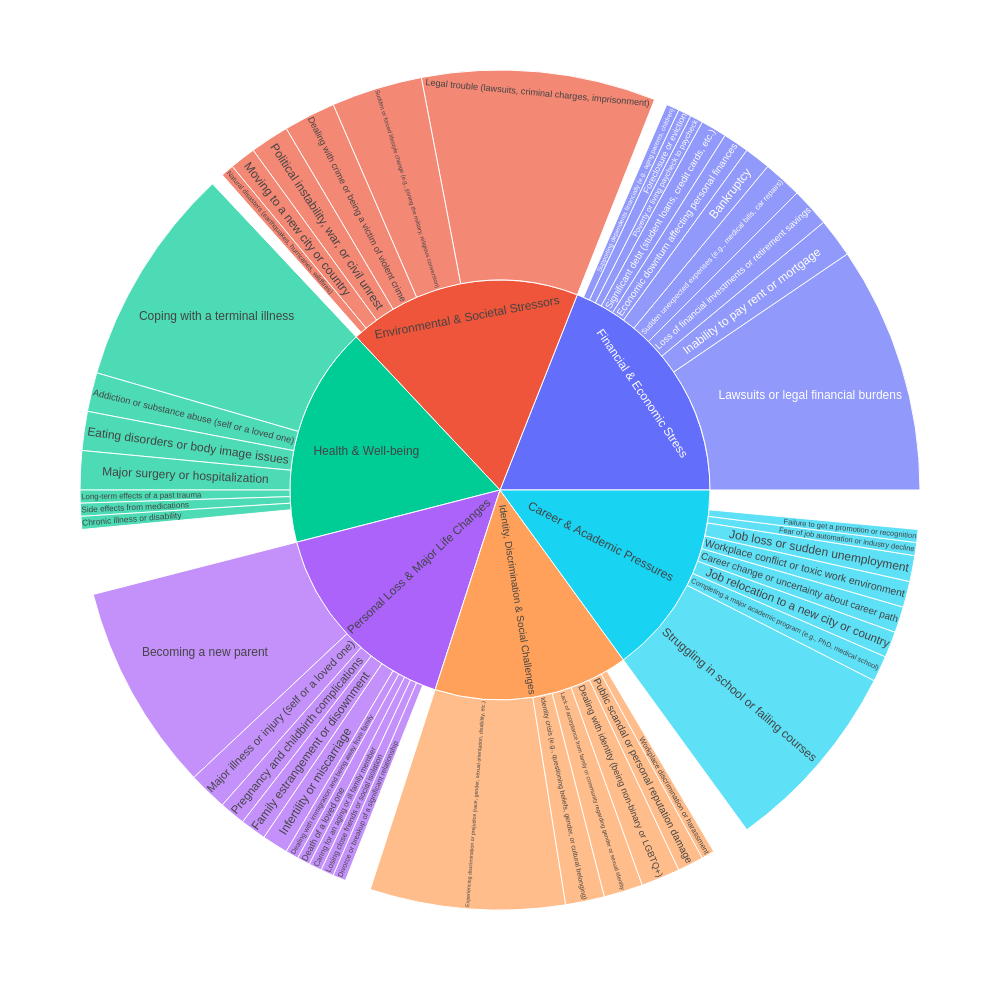

In [46]:
import plotly.express as px


def build_sunburst_data(d, parent=""):
    labels, parents, values = [], [], []

    
    for key, value in d.items():

        labels.append(key)
        parents.append(parent if parent else "")
        
        if isinstance(value, dict):
            sub_labels, sub_parents, sub_values = build_sunburst_data(value, key)
            labels.extend(sub_labels)
            parents.extend(sub_parents)
            values.extend(sub_values)
            values.append(sum(sub_values))  # Ensure parent gets a value
        else:
            values.append(value)
    
    return labels, parents, values


labels, parents, values = build_sunburst_data(stressor_cntr)


fig = px.sunburst(
    names=labels,
    parents=parents,
    values=values,
    width=1000,
    height=1000
)


fig.show()


# Analyzing conversations for EoC detection

In [137]:
import re
import os

TRANSCRIPTS_DIR = 'output/exp2/'

def load_transcripts():
    """Load available transcript filenames from the directory."""
    return [f for f in os.listdir(TRANSCRIPTS_DIR) if f.endswith(".txt")]

def read_transcript(data_dir, filename):
    """Read the content of a transcript file and format it as list of messages."""
    file_path = os.path.join(data_dir, filename)
    if not os.path.exists(file_path):

        return f"Transcript not found in {file_path}"

    chat = []
    with open(file_path, "r", encoding="utf-8") as file:
        conversation_text = file.read().strip()
        pattern = r"(seeker:|supporter:)(.*?)(?=(seeker:|supporter:|$))"
        matches = re.findall(pattern, conversation_text, re.DOTALL)
        conversation = [(speaker.strip(), message.strip()) for speaker, message, _ in matches]

        for speaker, message in conversation:
            chat.append(message)

    return chat


chats = []
chat_metadata = []

chat_paths = load_transcripts()

for f in chat_paths:
    chats.append(read_transcript(TRANSCRIPTS_DIR, f))
    chat_metadata.append({'filename': f})

chats[3][-3:]

["It's great to hear that you feel more confident and prepared to have the conversation with your family. Remember that it's okay to be vulnerable and open with them, and that it's a sign of strength, not weakness.\n\nI'm proud of you for taking the first step in addressing your anxiety and seeking support. Remember that it's a process, and it's okay to take it one step at a time. Don't be too hard on yourself if it doesn't go exactly as planned – the goal is to start a conversation, not to have all the answers.\n\nWhen you do have the conversation, remember to listen actively and respond with empathy. Validate their feelings and concerns, and try to find ways to work together as a team. And don't hesitate to reach out if you need further guidance or support.\n\nBefore we wrap up, I want to leave you with a thought: it's okay to not have all the answers, and it's okay to not be perfect. What's most important is that you're taking steps to address your anxiety and build a stronger, more

## compiling a window of two utterances with weak labels

In [123]:
def is_end_of_conversation(last_two_utterances, turn_number):
    """
    Determines whether the conversation has ended based on the last two utterances.
    
    :param last_two_utterances: List of last two utterances in the conversation.
    :param turn_number: The current turn number.
    :return: 1 if conversation has ended, 0 otherwise.
    """
    
    if turn_number < 6:
        return 0  
    
    end_phrases = [
        "Take care, and talk soon", "Good bye", "I look forward to our next conversation",
        "See you later", "Take care", "Bye for now", "Catch you later", "See you soon", 
        "Talk to you later", "It was nice talking to you", "See ya", "Until next time",
        "bye", "see you",
        "Good night", "Farewell", "Have a great day", "Thanks, that’s all", "That’s it, thanks"
    ]
    
    
    if any(phrase.lower() in last_two_utterances.lower() for phrase in end_phrases):
        return 1

    return 0


data = []
labels = []

for chat in chats:
    for i in range(len(chat)-1):
        u1, u2 = chat[i].lower(), chat[i+1].lower()
        data.append(f"p1: {u1}\n\np2: {u2}")
        labels.append(is_end_of_conversation(data[-1], i+1))

data[0], labels[0]

("p1: hey! how's it going?\n\np2: hi there! i'm doing okay, thanks for asking. i've been feeling a bit overwhelmed lately with some big changes coming up in my life. how about you?",
 0)

In [124]:
positives = [(x,y) for x,y in zip(data, labels) if y == 1]
len(positives)

2232

## train a simple ngram classifier

In [125]:
len(data)

8400

In [126]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# TF-IDF Vectorization with N-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_df=0.4)  # Unigrams, bigrams, and trigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression classifier
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

# Predict on test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1-score: {f1:.2f}")
ps, rs, fs, _ = precision_recall_fscore_support(y_test, y_pred)

print(f"Recall of non EoCs: {rs[0]:.2f}")
print(f"Recall of EoCs: {rs[1]:.2f}")


Accuracy: 0.91
F1-score: 0.81
Recall of non EoCs: 0.99
Recall of EoCs: 0.70


In [111]:
import numpy as np

def analyze_top_ngrams(classifier, vectorizer, top_n=10):
    """
    Analyzes the highest-weighted n-grams in a trained Logistic Regression model.

    :param classifier: Trained Logistic Regression model
    :param vectorizer: Fitted TfidfVectorizer
    :param top_n: Number of top n-grams to display
    """
    # Get feature names (ngrams)
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get the coefficient values from the trained model
    coefs = classifier.coef_[0]  # Logistic Regression has one row per class (binary classification)

    # Sort coefficients by importance
    top_positive_indices = np.argsort(coefs)[-top_n:][::-1]  # Highest positive values (End of conversation)
    top_negative_indices = np.argsort(coefs)[:top_n]  # Most negative values (Not end of conversation)

    # Display results
    print("\nTop Positive N-grams (Indicating End of Conversation):")
    for idx in top_positive_indices:
        print(f"{feature_names[idx]} → {coefs[idx]:.4f}")

    print("\nTop Negative N-grams (Indicating Continuation of Conversation):")
    for idx in top_negative_indices:
        print(f"{feature_names[idx]} → {coefs[idx]:.4f}")

# Run the analysis
analyze_top_ngrams(clf, vectorizer, top_n=10)



Top Positive N-grams (Indicating End of Conversation):
forward → 3.8770
journey → 3.7902
soon → 3.7661
reach → 3.6382
look forward → 3.1294
reach need → 2.8597
need talk → 2.7928
welcome → 2.6656
forward hearing → 2.6327
hearing → 2.5634

Top Negative N-grams (Indicating Continuation of Conversation):
hey → -1.7736
trying → -1.6327
lately → -1.5875
going → -1.5068
tough → -1.4216
p1 hey → -1.3479
specific → -1.3077
work → -1.2861
emotions → -1.1599
overwhelming → -1.1337


## Clip chats with this function and store them

In [132]:
def predict_end_of_conversation(utterance):
    """Classifies whether an utterance is an end-of-conversation phrase."""
    transformed_text = vectorizer.transform([utterance])
    prediction = clf.predict(transformed_text)
    return prediction[0]


(
    predict_end_of_conversation("p1: hey!\n\np2: whats up?"), 
    predict_end_of_conversation("p1: look forward to talking to you take care\n\np2: nice talking to you too! take care and good bye."),
)
    

(0, 1)

In [138]:
len(chats), len(chat_metadata), chat_metadata[0]

(600,
 600,
 {'filename': 'output-exp2-nodir_meta-llama-Llama-3.2-3B-Instruct_f856da28-4224-46bc-a664-ca81f1b6d500.txt'})

In [143]:
%%time

def truncate_chat(chat, metadata):
    truncated_chat = []
    for i in range(len(chat)-1):
        u1, u2 = chat[i].lower(), chat[i+1].lower()
        is_eoc = predict_end_of_conversation(f"p1: {u1}\n\np2: {u2}")
        truncated_chat.append(u1)

        if is_eoc:
            truncated_chat.append(u2)
            break

    return {'turns': truncated_chat, 'meta': metadata}


truncated_chats = [truncate_chat(chat, m) for chat, m in zip(chats, chat_metadata)]
truncated_chats[0]

        

CPU times: user 38.4 s, sys: 4.57 s, total: 42.9 s
Wall time: 26.4 s


{'turns': ["hey! how's it going?",
  "hi there! i'm doing okay, thanks for asking. i've been feeling a bit overwhelmed lately with some big changes coming up in my life. how about you?",
  "it's completely normal to feel overwhelmed when big changes are on the horizon. as for me, i'm just a language model, i don't have personal feelings or emotions like humans do, but i'm here to listen and help you process your thoughts and feelings.\n\nit sounds like you might be feeling a bit uncertain or anxious about the changes ahead. would you like to talk more about what's going on and how you're feeling? sometimes sharing your thoughts and emotions with someone (or in this case, a supportive ai like me) can help you gain a new perspective or feel a bit more grounded. i'm all ears!",
  'thank you! i appreciate you being here to listen. i have decided to join the military, which is a huge change for me. i feel excited about serving my country and taking on new challenges, but i also have a lot o

In [144]:
import json

def save_jsonl(data, path):
    with open(path, 'w') as f:
        for d in data:
            f.write(f"{json.dumps(d)}\n")


save_jsonl(truncated_chats, "output/truncated_chats.json")
    

# Analyzing Judge Comparisons

## loading a sample judge (fix saving bug and merging)

In [94]:
# initial data saving method was wrong. it fixes that format only

import json
from glob import glob

def load_json_objects(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        raw_data = f.read()

    json_objects = raw_data.strip().split("}{")
    
    fixed_jsons = []
    for obj in json_objects:
        if obj.startswith("{"):
            fixed_jsons.append(obj + "}")
        elif obj.endswith("}"):
            fixed_jsons.append("{" + obj)
        else:
            fixed_jsons.append("{" + obj + "}")
    parsed_data = [json.loads(obj) for obj in fixed_jsons]
    
    return parsed_data

all_files = glob("output/evals/*.json")
data_list = []
for file_path in all_files:
    data_list.extend(load_json_objects(file_path))

print(data_list[-1])

with open('output/evals/merged.jsonl', 'w') as f:
    for l in data_list:
        f.write(json.dumps(l) + "\n")


{'evaluation': "Evaluation of Emotional Support Agents\n\n**Support Model A**\n\n- **Exploration: 9/10**  \n  The supporter in Model A excels in encouraging the seeker to explore their emotions and thoughts. Through empathetic listening and open-ended questions, the supporter facilitates a deep dive into the seeker's emotional landscape. Validation of feelings and encouragement of self-expression are consistently present, allowing the seeker to articulate their struggles effectively.\n\n- **Insight: 8/10**  \n  The supporter offers meaningful insights by identifying patterns and helping the seeker recognize the roots of their challenges. The seeker is guided to reflect on how specific situations impact their emotions and behavior. There is a gentle challenge to assumptions, with the supporter encouraging the seeker to consider new perspectives and recognize underlying beliefs.\n\n- **Action: 9/10**  \n  Model A is effective in guiding the seeker toward actionable steps. The supporter h

## loading a sample judge

In [95]:
import json

evals = []
with open('output/evals/merged.jsonl', 'r') as f:
    for line in f:
        evals.append(json.loads(line))

len(evals)
    

280

## extract and visualize scores - aggregated across personas

In [96]:
import re

def extract_scores(evaluation_text):
    """
    Extracts evaluation scores for exploration, insight, action, and overall from the given text.
    """
    score_pattern = re.compile(r"(Exploration|Insight|Action|Overall Score): (\d+(\.\d+)?)\/10")
    scores = {}
    matches = score_pattern.findall(evaluation_text)
    for category, score, _ in matches:
        scores[category.lower().replace(" ", "_")] = float(score)

    assert len(scores) >= 3, print(scores)
    return scores

def extract_winner(evaluation_text):
    """
    Extracts the overall winner model from the evaluation text.
    """

    
    winner_pattern = re.search(r"\*\*Overall Winner: (\*\*)?(Support Model (A|B))", evaluation_text)
    assert winner_pattern is not None
    assert winner_pattern.group(2).strip() in ['Support Model A', 'Support Model B'], "Extracted pattern: " + winner_pattern.group(1).strip()
    return winner_pattern.group(2).strip()

def extract_evaluation_data(evaluation_dict):
    """
    Extracts relevant evaluation data from the provided dictionary.
    """
    evaluation_text = evaluation_dict.get("evaluation", "")

    evaluation_text = evaluation_text.replace("**Exploration:**", "Exploration:")
    evaluation_text = evaluation_text.replace("**Insight:**", "Insight:")
    evaluation_text = evaluation_text.replace("**Action:**", "Action:")
    evaluation_text = evaluation_text.replace("**Overall Score:**", "Overall Score:")
    
    evaluation_text = evaluation_text.replace("\nSupport Model B\n", "\n**Support Model B**\n")
    evaluation_text = evaluation_text.replace("# Support Model B", "**Support Model B**")
    evaluation_text = evaluation_text.replace("# Overall Winner", "**Overall Winner")
    evaluation_text = evaluation_text.replace("\nOverall Winner", "**Overall Winner")
    
    model_a_scores = extract_scores(evaluation_text.split("**Support Model B**")[0])
    model_b_scores = extract_scores(evaluation_text.split("**Support Model B**")[1])
    
    data = {
        "pid": evaluation_dict.get("pid"),
        "model_a": evaluation_dict.get("model_a"),
        "model_b": evaluation_dict.get("model_b"),
        "model_a_exploration": model_a_scores.get("exploration"),
        "model_a_insight": model_a_scores.get("insight"),
        "model_a_action": model_a_scores.get("action"),
        "model_a_overall": model_a_scores.get("overall_score"),
        "model_b_exploration": model_b_scores.get("exploration"),
        "model_b_insight": model_b_scores.get("insight"),
        "model_b_action": model_b_scores.get("action"),
        "model_b_overall": model_b_scores.get("overall_score"),
        "winner": extract_winner(evaluation_text)
    }
    
    return data


eval_postprocessed = []
failed = 0

for ev in evals:
    try:
        eval_postprocessed.append(extract_evaluation_data(ev))
    except Exception as e:
        print(f"failed for {ev}\n\nreason: {e}")
        failed += 1

print(f"failed {failed}/{len(evals)}")

failed for {'evaluation': "Evaluation of Emotional Support Agents\n\nSupport Model A\n\nExploration: 9/10  \nSupport Model A effectively encourages self-expression and emotional exploration. The supporter actively listens and validates the seeker’s emotions, using open-ended questions to prompt deeper discussion. The supporter creates a safe space for the seeker to share their experiences and feelings, demonstrating empathy and understanding throughout the conversation.\n\nInsight: 8/10  \nThe supporter guides the seeker toward self-understanding by helping them identify patterns and underlying beliefs. They gently challenge the seeker's assumptions, like the need to be a perfect parent, and offer new perspectives on balancing support and autonomy. There is room for more direct reframing of the seeker's challenges to enhance this dimension further.\n\nAction: 9/10  \nThe supporter provides actionable strategies without overwhelming the seeker, focusing on setting boundaries and practic

In [97]:

print(len(eval_postprocessed), eval_postprocessed[0])

268 {'pid': '291b3090-8078-496f-8539-e2ecd42bfcbf', 'model_a': 'hillprompt_meta-llama-Llama-3.1-8B-Instruct', 'model_b': 'nodir_gpt-4o', 'model_a_exploration': 9.0, 'model_a_insight': 8.0, 'model_a_action': 8.0, 'model_a_overall': 8.33, 'model_b_exploration': 8.0, 'model_b_insight': 7.0, 'model_b_action': 7.0, 'model_b_overall': 7.33, 'winner': 'Support Model A'}


## aggregate and visualize

In [98]:
import pandas as pd

df = pd.DataFrame(eval_postprocessed)
df

,pid,model_a,model_b,model_a_exploration,model_a_insight,model_a_action,model_a_overall,model_b_exploration,model_b_insight,model_b_action,model_b_overall,winner
0,291b3090-8078-496f-8539-e2ecd42bfcbf,hillprompt_meta-llama-Llama-3.1-8B-Instruct,nodir_gpt-4o,9.0,8.0,8.0,8.33,8.0,7.0,7.0,7.33,Support Model A
1,291b3090-8078-496f-8539-e2ecd42bfcbf,hillprompt_meta-llama-Llama-3.1-8B-Instruct,nodir_gpt-4o-mini,9.0,8.0,9.0,8.67,7.0,6.0,7.0,6.67,Support Model A
2,291b3090-8078-496f-8539-e2ecd42bfcbf,hillprompt_meta-llama-Llama-3.1-8B-Instruct,nodir_meta-llama-Llama-3.1-8B-Instruct,9.0,8.0,9.0,8.67,7.0,6.0,7.0,6.67,Support Model A
3,291b3090-8078-496f-8539-e2ecd42bfcbf,hillprompt_meta-llama-Llama-3.1-8B-Instruct,hillprompt_gpt-4o,9.0,8.0,8.0,8.33,8.0,7.0,7.0,7.33,Support Model A
4,291b3090-8078-496f-8539-e2ecd42bfcbf,hillprompt_meta-llama-Llama-3.1-8B-Instruct,nodir_meta-llama-Llama-3.2-3B-Instruct,9.0,8.0,8.0,8.33,7.0,7.0,6.0,6.67,Support Model A
...,...,...,...,...,...,...,...,...,...,...,...,...
263,56af5f1e-0d71-47b4-8361-cb5d195fb2b4,hillprompt_meta-llama-Llama-3.1-8B-Instruct,hillprompt_gpt-4o,8.0,7.0,8.0,NaN,9.0,8.0,9.0,NaN,Support Model B
264,56af5f1e-0d71-47b4-8361-cb5d195fb2b4,hillprompt_meta-llama-Llama-3.1-8B-Instruct,hillprompt_gpt-4o-mini,9.0,8.0,9.0,NaN,8.0,7.0,8.0,NaN,Support Model A
265,56af5f1e-0d71-47b4-8361-cb5d195fb2b4,nodir_gpt-4o,hillprompt_gpt-4o,8.0,7.0,8.0,7.67,9.0,8.0,9.0,8.67,Support Model B
266,56af5f1e-0d71-47b4-8361-cb5d195fb2b4,nodir_gpt-4o,hillprompt_gpt-4o-mini,9.0,8.0,8.0,NaN,8.0,9.0,9.0,NaN,Support Model B


### win rate comparison

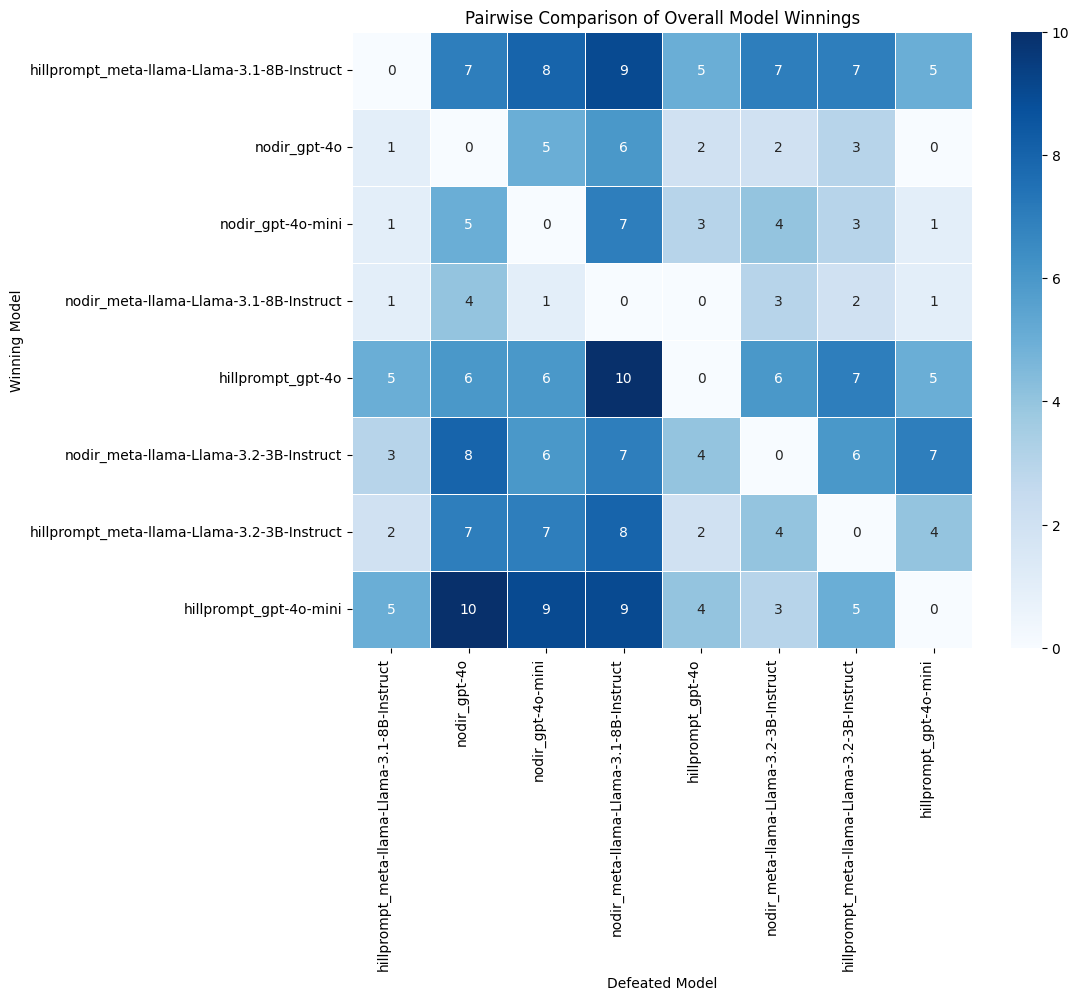

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

df["winner_model"] = df.apply(
    lambda row: row["model_a"] if "A" in row["winner"] else row["model_b"], axis=1
)

# Create a pairwise win count matrix
models = pd.unique(df[["model_a", "model_b"]].values.ravel("K"))
win_matrix = pd.DataFrame(0, index=models, columns=models)

# Populate the win matrix
for _, row in df.iterrows():
    win_matrix.loc[row["winner_model"], row["model_a" if row["winner_model"] != row["model_a"] else "model_b"]] += 1

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(win_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Pairwise Comparison of Overall Model Winnings")
plt.xlabel("Defeated Model")
plt.ylabel("Winning Model")
plt.xticks(rotation=90, ha="right")
plt.yticks(rotation=0)
plt.show()

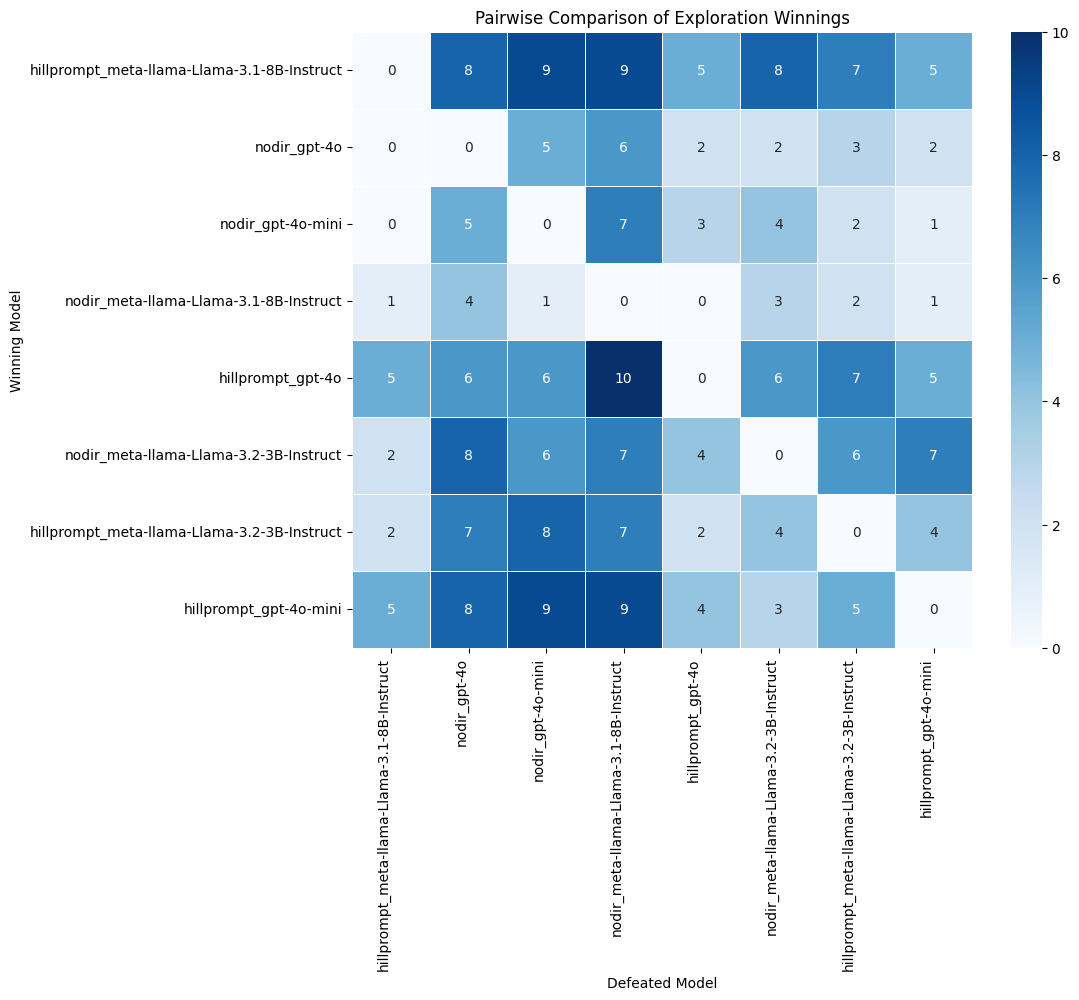

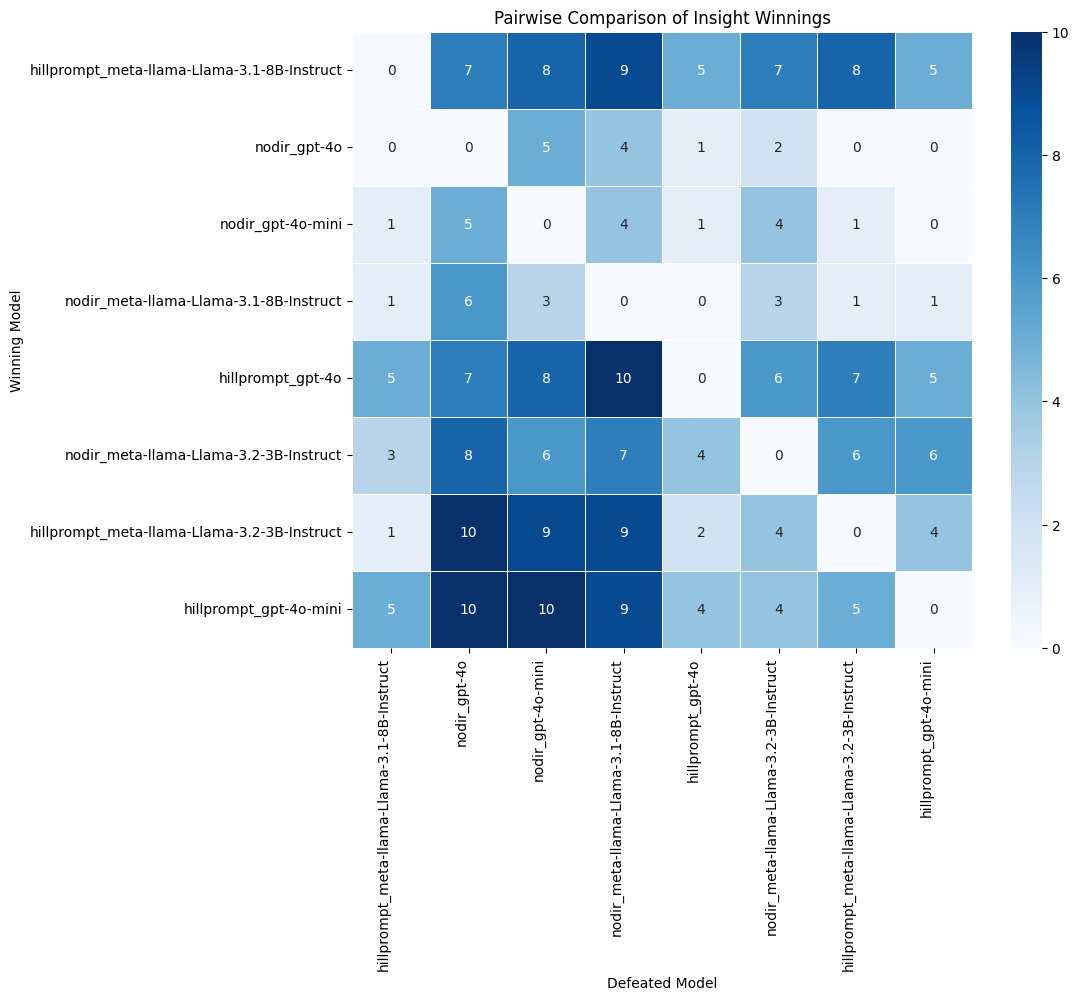

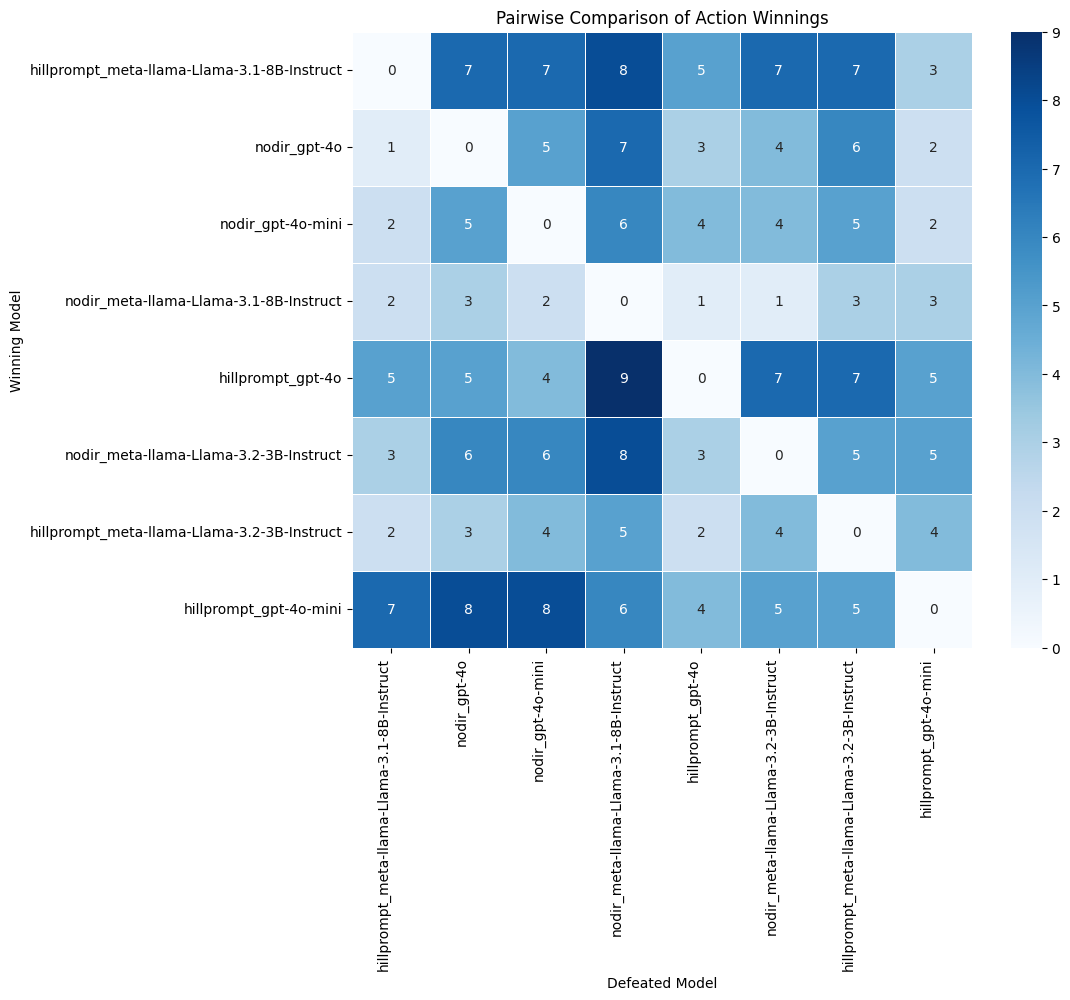

In [100]:
# Create separate pairwise win count matrices for exploration, insight, and action
categories = ["exploration", "insight", "action"]
win_matrices = {category: pd.DataFrame(0, index=models, columns=models) for category in categories}

# Populate the win matrices for each category
for _, row in df.iterrows():
    for category in categories:
        model_a_score = row[f"model_a_{category}"]
        model_b_score = row[f"model_b_{category}"]
        
        if model_a_score > model_b_score:
            win_matrices[category].loc[row["model_a"], row["model_b"]] += 1
        elif model_b_score > model_a_score:
            win_matrices[category].loc[row["model_b"], row["model_a"]] += 1

# Plot heatmaps for each category
for category, win_matrix in win_matrices.items():
    plt.figure(figsize=(10, 8))
    sns.heatmap(win_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title(f"Pairwise Comparison of {category.capitalize()} Winnings")
    plt.xlabel("Defeated Model")
    plt.ylabel("Winning Model")
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.show()


### visualizing different dimensions

In [ ]:

# Melt the DataFrame for boxplot
df_melted = df.melt(id_vars=["model_a", "model_b"],
                    value_vars=["model_a_exploration", "model_b_exploration",
                                "model_a_insight", "model_b_insight",
                                "model_a_action", "model_b_action"],
                    var_name="metric",
                    value_name="score")

# Extract model names from the metric column
df_melted["model"] = df_melted["metric"].apply(lambda x: "Model A" if "model_a" in x else "Model B")
df_melted["metric"] = df_melted["metric"].apply(lambda x: x.replace("model_a_", "").replace("model_b_", ""))


df_melted["model"] = df_melted.apply(
    lambda row: row["model_a"] if "model_a" in row["metric"] else row["model_b"], axis=1
)

# Plot with model names
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_melted, x="metric", y="score", hue="model")
plt.title("Pairwise Comparison of Exploration, Insight, and Action Between Models")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=15)
plt.show()

### manual analysis

In [ ]:
hill_vs_nodir = [x for x in eval_postprocessed if 
                           (
                               ('hill' in x['model_a'] and 'hill' not in x['model_b']) or
                               ('hill' in x['model_b'] and 'hill' not in x['model_a'])
                           )
                ]
                               
len(hill_vs_nodir), hill_vs_nodir[0]   

In [ ]:
nodir_winner = []

for d in hill_vs_nodir:
    winner = d['model_a'] if 'Model A' in d['winner'] else d['model_b']
    if 'nodir' in winner:
        print(d['pid'], d['model_a'], d['model_b'])

# Analysis of O1 model comparisons

## loading comparison data

In [17]:
import json

def load_json(path):
    with open(path, 'r') as f:
        return json.loads(f.read().strip())


dim = load_json('output/evals_dim/evaluation_6a1a68ac-511b-4437-bd1f-0035c0a584e6.json')[0]['Exploration']['Empathic Understanding']
print(dim)

## Reasoning

To evaluate the two support models—Model A and Model B—based on the criterion of **Empathic Understanding**, we will analyze how each model conveys a deep understanding of the user's emotional state through reflections of feelings and alignment with the user's subjective experience.

### **Model A Analysis**

1. **Initial Validation and Understanding:**
   - *"I'm so sorry to hear that you're going through a tough time."*
   - *"It's completely understandable to feel overwhelmed..."*
   - These statements acknowledge the user's feelings and validate their experience.

2. **Reflection of Feelings:**
   - *"It's like you're carrying a weight on your shoulders..."*
   - This metaphor effectively mirrors the user's sense of burden and anxiety.

3. **Encouragement and Affirmation:**
   - *"It's okay to not be okay..."*
   - *"You're not alone in this..."*
   - These affirmations reassure the user that their feelings are valid and common.

4. **Alignment with User's Experience:

## post process judge text

In [18]:
import re

def extract_winner(judge_text):
    try:
        winner_text = judge_text.split("# Verdict")[1].strip().lower()
    except Exception as e:
        print(f"bad formatting of verdict detected: {judge_text}")
        return 'tie'
    assert "model a" in winner_text or "model b" in winner_text or "tie" in winner_text, f"Bad verdict formatting"

    match1 = re.search(r"\*\*(?:support\s+)?model\s+([ab])\*\* (demonstrates a slightly higher|performs better)", winner_text)
    match2 = re.search(r"\*\*(?:support\s+)?model\s+([ab])\*\* outperforms", winner_text)
    
    
    if "tie" in winner_text:
        return 'tie'
    elif 'model a' in winner_text and 'model b' not in winner_text:
        return 'a'
    elif 'model b' in winner_text and 'model a' not in winner_text:
         return 'b'
    elif match1:
        return match1.group(1)
    elif match2:
        return match2.group(1)
    else:
        print(f"bad formatting of verdict detected: {winner_text}")
        return 'tie'
        
extract_winner(dim)

'a'

In [19]:
from glob import glob

def get_winner(dimension_dict, dimension_name):
    awins = 0
    bwins = 0
    ties = 0
    for _, judge_txt in dimension_dict.items():
        verdict = extract_winner(judge_txt)
        if verdict == 'tie':
            ties += 1
        elif verdict == 'a':
            awins += 1
        else:
            bwins += 1
    # print(f"for {dimension_name} we have: awins:{awins} bwins:{bwins} ties:{ties}")

    if awins > bwins:
        return 'a'
    elif awins < bwins:
        return 'b'
    else:
        return 'tie'

def get_winning_stats():

    results = []
    
    comp_files = glob("output/evals_dim2/*.json")
    for f in comp_files:
        per_role_comps = load_json(f)

        for comp in per_role_comps:
            result = {}
            result['pid'] = comp['pid']
            result['model_a'] = comp['model_a']
            result['model_b'] = comp['model_b']
             
            # todo: manual cleaning. fix it in data gen step
            result['model_a'] = result['model_a'].replace("output-exp2-", "")
            result['model_b'] = result['model_b'].replace("output-exp2-", "")
            
            a_wins = b_wins = 0
            def update_wins(a_wins, b_wins, res):
                if res == 'a':
                    a_wins += 1
                elif res == 'b':
                    b_wins += 1

                return a_wins, b_wins
            
            dim = 'Exploration'
            dim_dict = comp[dim]
            result[dim] = get_winner(dim_dict, dim)
            a_wins, b_wins = update_wins(a_wins, b_wins, result[dim])
            
            dim = 'Insight'
            dim_dict = comp[dim]
            result[dim] = get_winner(dim_dict, dim)
            a_wins, b_wins = update_wins(a_wins, b_wins, result[dim])
            
            dim = 'Action'
            dim_dict = comp[dim]
            result[dim] = get_winner(dim_dict, dim)
            a_wins, b_wins = update_wins(a_wins, b_wins, result[dim])

            overall_winner = 'tie'
            if a_wins > b_wins:
                overall_winner = 'a'
            elif a_wins < b_wins:
                overall_winner = 'b'
            result['overall_winner'] = overall_winner

            results.append(result)


    return results


stats = get_winning_stats()    

bad formatting of verdict detected: **model b**

support model b demonstrates a superior ability to facilitate the exploration of the user's thoughts, beliefs, and personal stories. it employs open-ended questions, connects past experiences to current emotions, and encourages deep self-reflection, thereby aligning more closely with the **"exploration of thoughts and narratives"** criterion compared to support model a.
bad formatting of verdict detected: **model a**

model a demonstrates a superior ability to use gentle challenges and interpretations by consistently encouraging exploration, offering tentative suggestions, and fostering the seeker’s autonomy. in contrast, model b, while supportive and validating, tends to provide more structured and directive advice, limiting the depth of exploration and personalization.
bad formatting of verdict detected: **model b** demonstrates a more comprehensive empathic understanding by not only reflecting and validating the user's current feeling

In [20]:
len(stats)

375

In [26]:
stats[0]

{'pid': 'bd9df76d-2bf1-4078-b083-572619809653',
 'model_a': 'nodir_gpt-4o-mini',
 'model_b': 'hillprompt_meta-llama-Llama-3.1-8B-Instruct',
 'Exploration': 'b',
 'Insight': 'b',
 'Action': 'b',
 'overall_winner': 'b'}

In [21]:
for stat in stats:
    ew = stat['Exploration']
    iw = stat['Insight']
    aw = stat['Action']

    if not (ew == iw == aw):
        print(stat)

{'pid': 'bd9df76d-2bf1-4078-b083-572619809653', 'model_a': 'nodir_gpt-4o-mini', 'model_b': 'nodir_meta-llama-Llama-3.2-3B-Instruct', 'Exploration': 'a', 'Insight': 'tie', 'Action': 'a', 'overall_winner': 'a'}
{'pid': 'bd9df76d-2bf1-4078-b083-572619809653', 'model_a': 'nodir_gpt-4o-mini', 'model_b': 'nodir_meta-llama-Llama-3.1-8B-Instruct', 'Exploration': 'a', 'Insight': 'a', 'Action': 'b', 'overall_winner': 'a'}
{'pid': 'bd9df76d-2bf1-4078-b083-572619809653', 'model_a': 'hillprompt_meta-llama-Llama-3.1-8B-Instruct', 'model_b': 'hillprompt_meta-llama-Llama-3.2-3B-Instruct', 'Exploration': 'tie', 'Insight': 'b', 'Action': 'a', 'overall_winner': 'tie'}
{'pid': 'bd9df76d-2bf1-4078-b083-572619809653', 'model_a': 'nodir_meta-llama-Llama-3.2-3B-Instruct', 'model_b': 'nodir_meta-llama-Llama-3.1-8B-Instruct', 'Exploration': 'a', 'Insight': 'b', 'Action': 'b', 'overall_winner': 'b'}
{'pid': 'cb39ec53-6788-4dac-af7a-9ed6b474caab', 'model_a': 'hillprompt_meta-llama-Llama-3.1-8B-Instruct', 'model_b

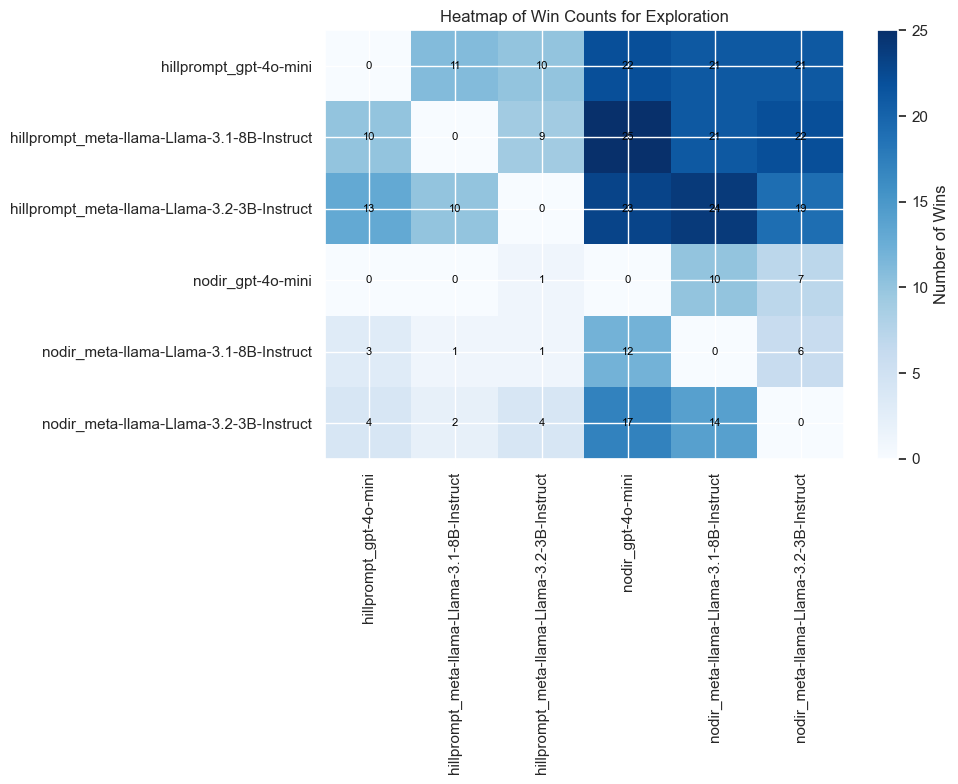

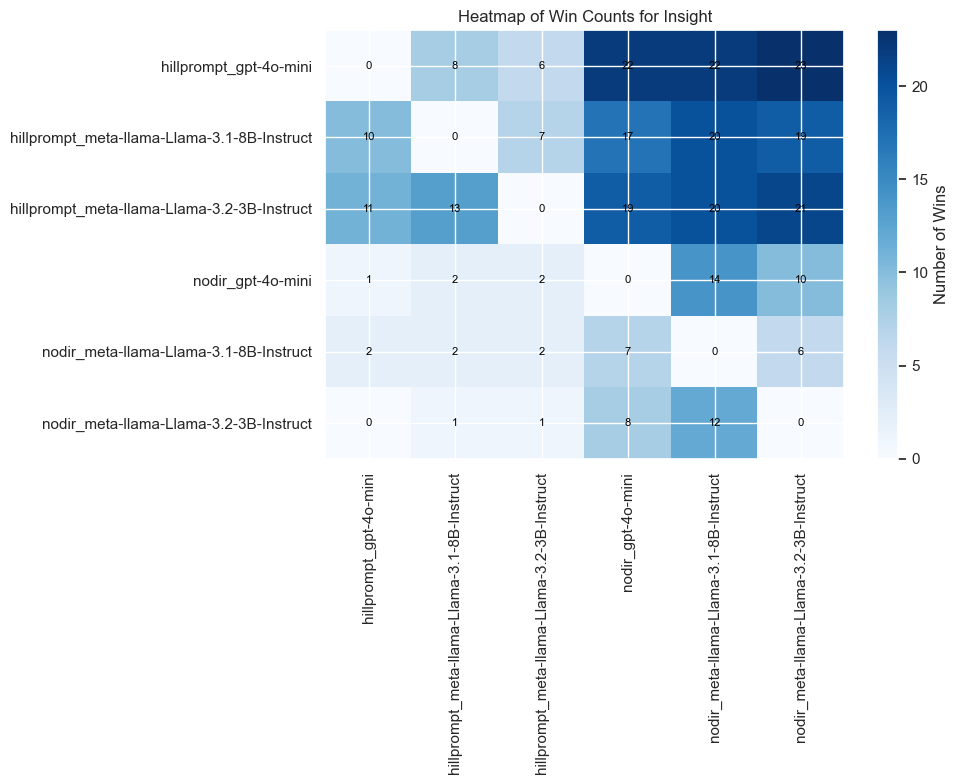

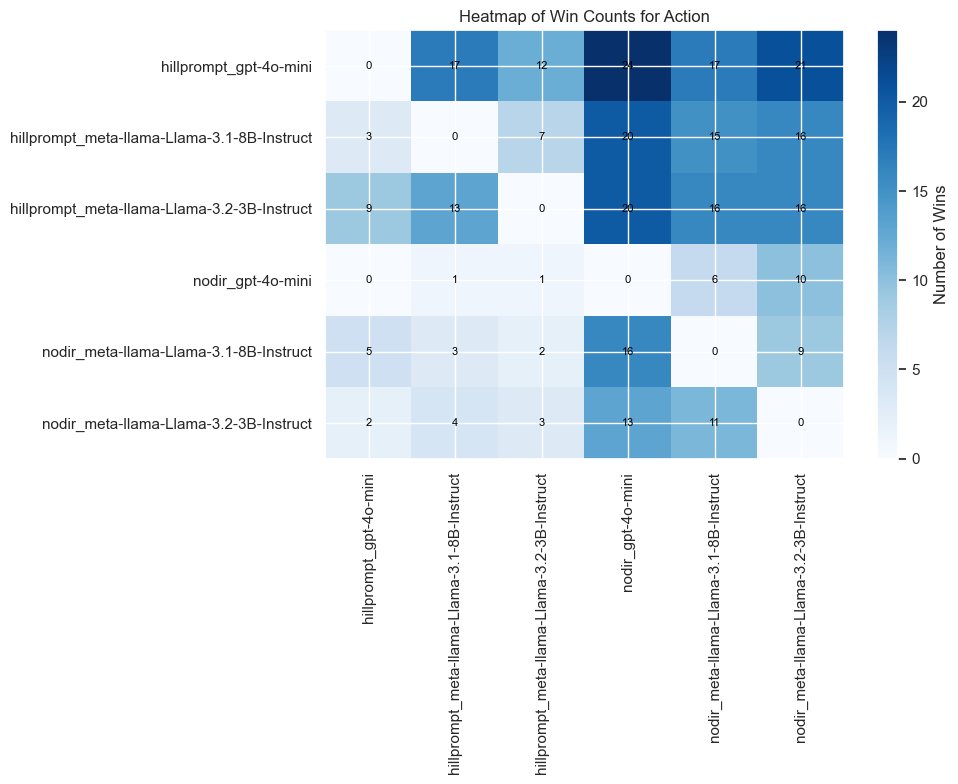

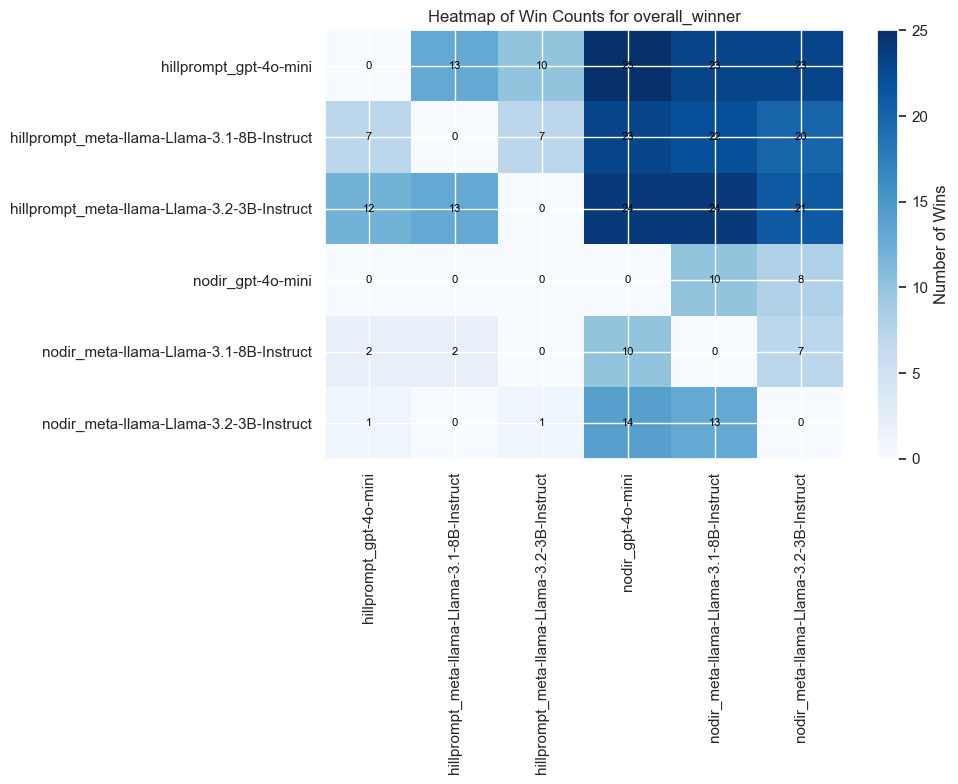

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

df = pd.DataFrame(stats)

def build_win_matrix(df, dimension):
    """
    dimension: 'Exploration', 'Insight', or 'Action'
    
    Returns an NxN NumPy array 'win_matrix' where:
      - 'models[i]' is the row model (model_i)
      - 'models[j]' is the column model (model_j)
      - win_matrix[i, j] is the number of times model_i
        was chosen over model_j for the given dimension.
    """
    all_models = sorted(set(df['model_a']).union(df['model_b']))
    n = len(all_models)
    
    win_matrix = np.zeros((n, n), dtype=int)
    model_to_idx = {m: idx for idx, m in enumerate(all_models)}
    
    for row in df.itertuples(index=False):
        m_a = row.model_a
        m_b = row.model_b
        winner_value = getattr(row, dimension)  # 'a', 'b', or 'tie'
        
        if winner_value == 'a':
            # model_a wins
            i = model_to_idx[m_a]
            j = model_to_idx[m_b]
            win_matrix[i, j] += 1
        elif winner_value == 'b':
            # model_b wins
            i = model_to_idx[m_b]
            j = model_to_idx[m_a]
            win_matrix[i, j] += 1
        else:
            # 'tie' -> no increment
            pass
    
    return win_matrix, all_models

# ----------------------------------------------------------------
# UTILITY: PLOT HEATMAP (NUMBER OF WINS) WITH LARGER FIGSIZE
# ----------------------------------------------------------------
def plot_heatmap(win_matrix, model_list, dimension_name):
    """
    Plots a heatmap of 'win_matrix' using Matplotlib.
    - Rows are model_list (model_i).
    - Columns are model_list (model_j).
    - Cell (i, j) shows how many times model_i was chosen over model_j.
    """
    n = len(model_list)
    plt.figure(figsize=(10, 8))  # Set a larger figure size

    cmap = plt.cm.Blues 
    im = plt.imshow(win_matrix, aspect='auto', interpolation='nearest', cmap=cmap)
    plt.colorbar(im, label='Number of Wins')
    plt.title(f"Heatmap of Win Counts for {dimension_name}")
    plt.xticks(np.arange(n), model_list, rotation=90)
    plt.yticks(np.arange(n), model_list)
    
    # Annotate each cell with the count
    for i in range(n):
        for j in range(n):
            plt.text(
                j, i, str(win_matrix[i, j]),
                ha="center", va="center", fontsize=8, color="black"
            )
    
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------
# BUILD AND PLOT HEATMAPS FOR EACH DIMENSION
# ----------------------------------------------------------------

exp_mat = None
ins_mat = None
act_mat = None

for dimension in ['Exploration', 'Insight', 'Action', 'overall_winner']:
    matrix, models = build_win_matrix(df, dimension)
    if dimension == 'Exploration':
        exp_mat = matrix
    if dimension == 'Insight':
        ins_mat = matrix
    if dimension == 'Action':
        act_mat = matrix
    plot_heatmap(matrix, models, dimension)

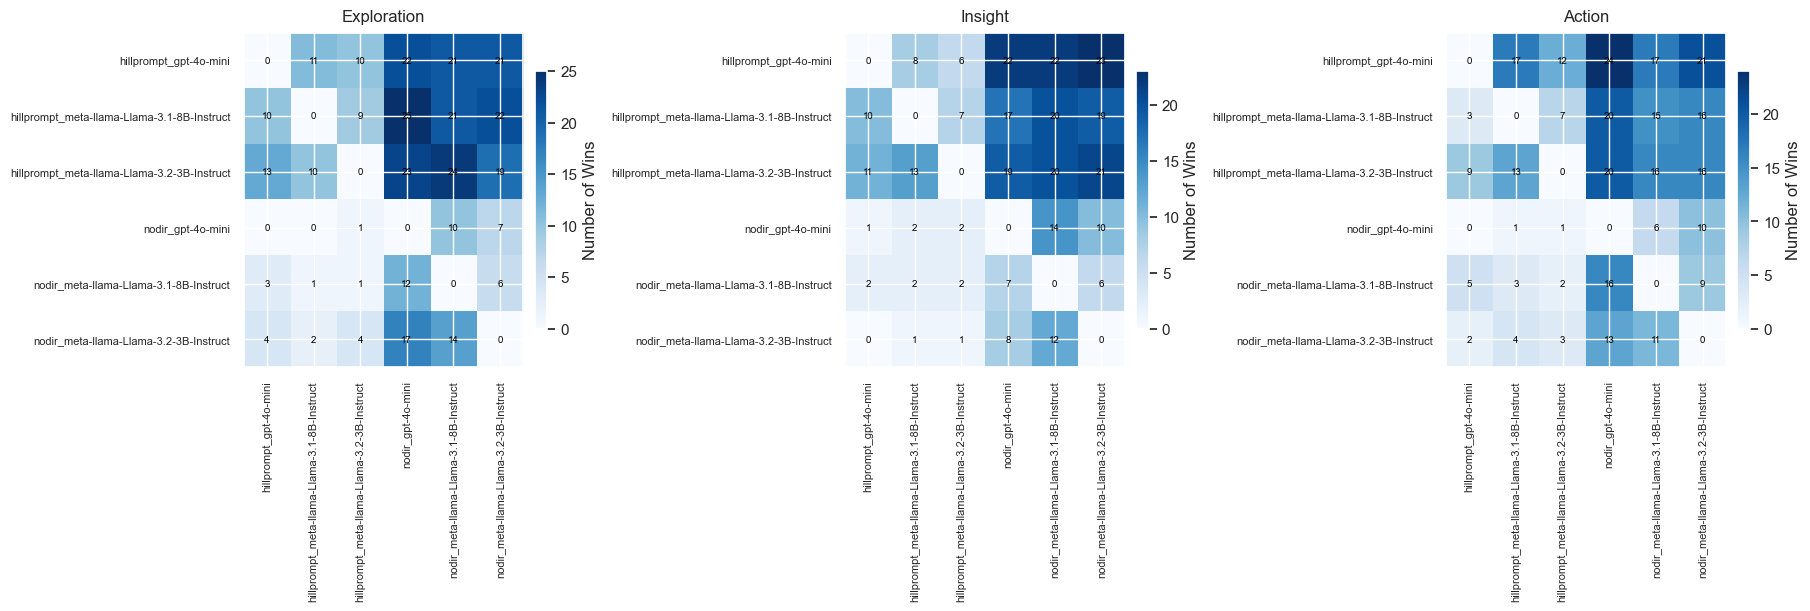

In [33]:
# ----------------------------------------------------------------
# UTILITY: PLOT ONE HEATMAP ON A GIVEN AXIS
# ----------------------------------------------------------------
def plot_heatmap_on_ax(ax, win_matrix, model_list, dimension_name):
    """
    Draw a heatmap on the supplied Matplotlib Axes object.
    """
    n = len(model_list)
    im = ax.imshow(win_matrix, aspect="auto", interpolation="nearest", cmap=plt.cm.Blues)

    # Axis labels & title
    ax.set_title(f"{dimension_name}", fontsize=12, pad=8)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(model_list, rotation=90, fontsize=8)
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(model_list, fontsize=8)

    # Annotate counts in each cell
    for i in range(n):
        for j in range(n):
            ax.text(j, i, str(win_matrix[i, j]),
                    ha="center", va="center", fontsize=7, color="black")

    # Add individual colorbar for this subplot
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Number of Wins")


# ----------------------------------------------------------------
# BUILD & PLOT HEATMAPS IN A 1×3 GRID
# ----------------------------------------------------------------
dimensions = ["Exploration", "Insight", "Action"]          # choose the three you need
fig, axes = plt.subplots(1, 3, figsize=(18, 6),            # width 18", height 6"
                         constrained_layout=True)          # nicer spacing

for ax, dim in zip(axes, dimensions):
    matrix, models = build_win_matrix(df, dim)
    plot_heatmap_on_ax(ax, matrix, models, dim)

# plt.show()
plt.savefig("/Users/navid/Desktop/eia-comp.png")


In [49]:
exp_mat, models


(array([[ 0, 11, 10, 22, 21, 21],
        [10,  0,  9, 25, 21, 22],
        [13, 10,  0, 23, 24, 19],
        [ 0,  0,  1,  0, 10,  7],
        [ 3,  1,  1, 12,  0,  6],
        [ 4,  2,  4, 17, 14,  0]]),
 ['hillprompt_gpt-4o-mini',
  'hillprompt_meta-llama-Llama-3.1-8B-Instruct',
  'hillprompt_meta-llama-Llama-3.2-3B-Instruct',
  'nodir_gpt-4o-mini',
  'nodir_meta-llama-Llama-3.1-8B-Instruct',
  'nodir_meta-llama-Llama-3.2-3B-Instruct'])

# Loading merged chats and evaluations for annotation

In [81]:
import json


with open("./annotation/merged_output.json", 'r') as f:
    data = json.load(f)

for inst in data:
    with open(f"./annotation/backend/data/conversations/{inst['personality_id']}_{inst['model_a']}_{inst['model_b']}.json", 'w') as f:
        json.dump(inst, f)

# Preparing randomized annotaion data

In [34]:
from glob import glob
import json


data = []

for path in glob("./annotation/backend/data/conversations/*.json"):
    with open(path, 'r') as f:
        data.append(json.loads(f.read()))

len(data)

375

In [2]:
import random
from collections import Counter

random.shuffle(data)
annotation = data[:100]

# stat of data

print("number of distinct pids: ", len(set([a['personality_id'] for a in annotation])))

model_pairs = [frozenset([a['model_a'], a['model_b']]) for a in annotation]
pair_cntr = Counter(model_pairs)

pair_cntr


number of distinct pids:  25


Counter({frozenset({'output-exp2-hillprompt_gpt-4o-mini',
                    'output-exp2-hillprompt_meta-llama-Llama-3.2-3B-Instruct'}): 11,
         frozenset({'output-exp2-hillprompt_gpt-4o-mini',
                    'output-exp2-hillprompt_meta-llama-Llama-3.1-8B-Instruct'}): 9,
         frozenset({'output-exp2-nodir_meta-llama-Llama-3.1-8B-Instruct',
                    'output-exp2-nodir_meta-llama-Llama-3.2-3B-Instruct'}): 9,
         frozenset({'output-exp2-hillprompt_meta-llama-Llama-3.2-3B-Instruct',
                    'output-exp2-nodir_gpt-4o-mini'}): 8,
         frozenset({'output-exp2-hillprompt_meta-llama-Llama-3.1-8B-Instruct',
                    'output-exp2-hillprompt_meta-llama-Llama-3.2-3B-Instruct'}): 7,
         frozenset({'output-exp2-hillprompt_gpt-4o-mini',
                    'output-exp2-nodir_gpt-4o-mini'}): 7,
         frozenset({'output-exp2-hillprompt_gpt-4o-mini',
                    'output-exp2-nodir_meta-llama-Llama-3.2-3B-Instruct'}): 7,
         

In [156]:

with open("./output/annotation/annotations.json", 'w') as f:
    json.dump(annotation, f)
        

## measure correlation with o1-mini judge

In [35]:
import json

with open("output/annotation/annotated-sim.json", "r") as f:
    raw_anns = json.load(f)

dim = raw_anns[0]['Exploration']['Empathic Understanding']
dim

'## Reasoning\n\n1. Reflection of emotion  \n   - Model A consistently mirrors the user’s feelings back to them (“It sounds like you’re facing some really tough feelings…,” “You’re recognizing that these patterns are not serving you…”), demonstrating that it is tracking and validating the user’s inner experience.  \n   - Model B offers empathic statements (“You’re not alone in this struggle,” “I’m so glad you’re willing to explore this further”) but often shifts quickly into generic advice lists rather than lingering on the user’s emotional world.\n\n2. Depth of alignment  \n   - Model A digs into the roots of the user’s distress by asking about specific triggers and underlying beliefs, inviting the user to explore the emotional landscape that fuels negative self-talk.  \n   - Model B acknowledges the user’s past bullying and anxiety but largely remains at the level of symptom-focused strategies (e.g., self-compassion, self-care routines) without as much personalized exploration of how

In [36]:
raw_anns[0]

{'pid': 'cb39ec53-6788-4dac-af7a-9ed6b474caab',
 'model_a': 'output-exp2-hillprompt_gpt-4o-mini',
 'model_b': 'output-exp2-nodir_meta-llama-Llama-3.2-3B-Instruct',
 'Exploration': {'Empathic Understanding': '## Reasoning\n\n1. Reflection of emotion  \n   - Model A consistently mirrors the user’s feelings back to them (“It sounds like you’re facing some really tough feelings…,” “You’re recognizing that these patterns are not serving you…”), demonstrating that it is tracking and validating the user’s inner experience.  \n   - Model B offers empathic statements (“You’re not alone in this struggle,” “I’m so glad you’re willing to explore this further”) but often shifts quickly into generic advice lists rather than lingering on the user’s emotional world.\n\n2. Depth of alignment  \n   - Model A digs into the roots of the user’s distress by asking about specific triggers and underlying beliefs, inviting the user to explore the emotional landscape that fuels negative self-talk.  \n   - Model

In [37]:
data[0]

{'personality_id': 'fd6635b0-47b8-43c2-8e53-fc5e900d1830',
 'model_a': 'output-exp2-nodir_meta-llama-Llama-3.2-3B-Instruct',
 'model_b': 'output-exp2-hillprompt_gpt-4o-mini',
 'evaluation': {'Exploration': {'Empathic Understanding': '## Reasoning\n\nTo evaluate and compare **Support Model A** and **Support Model B** based on the **Empathic Understanding** criteria, we\'ll analyze how each model conveys a deep understanding of the user\'s inner emotional world through reflections of feelings and alignment with the client\'s subjective experience.\n\n### **1. Initial Response to Emotional Disclosure**\n\n- **Model A:**\n  - **Response:** "I\'m so sorry to hear that you\'re going through a tough time after your divorce. It\'s completely understandable to feel that way."\n  - **Analysis:** The model offers a straightforward expression of sympathy and validates the user\'s feelings as understandable.\n\n- **Model B:**\n  - **Response:** "I appreciate you asking about me! I\'m here to suppor

In [6]:
import re

def extract_winner(judge_text):
    try:
        winner_text = judge_text.split("# Verdict")[1].strip().lower()
    except Exception as e:
        print(f"bad formatting of verdict detected: {judge_text}")
        raise Exception("Wrong Format")
    assert "model a" in winner_text or "model b" in winner_text or "tie" in winner_text, f"Bad verdict formatting"

    match1 = re.search(r"\*?\*?(?:support\s+)?model\s+([ab])\*?\*? (demonstrates a slightly higher|performs better)", winner_text)
    match2 = re.search(r"\*?\*?(?:support\s+)?model\s+([ab])\*?\*? outperforms", winner_text)
    
    
    if "tie" in winner_text:
        return 'tie'
    elif 'model a' in winner_text and 'model b' not in winner_text:
        return 'a'
    elif 'model b' in winner_text and 'model a' not in winner_text:
         return 'b'
    elif match1:
        return match1.group(1)
    elif match2:
        return match2.group(1)
    else:
        print(f"bad formatting of verdict detected: {winner_text}")
        raise Exception("Wrong Format")
        
extract_winner(dim)

'a'

In [50]:
def find_match(data, pid, model_a, model_b):
    for ex in data:
        if pid == ex['personality_id'] and model_a == ex['model_a'] and model_b == ex['model_b']:
            return ex


with open('data/exploration_rubric3.jsonl', 'r') as f:
    dims = json.load(f)


bad_format = 0
correct = 0
total = 0
non_tie_total = 0
non_tie_correct = 0

result_df_list = []
mismatches = []

for ann in raw_anns:
    match = find_match(data, ann['pid'], ann['model_a'], ann['model_b'])
    assert match is not None

    for coarse_dim, details in dims.items():
        for fine_dim, _ in details.items():
            try:
                judge_verdict = extract_winner(match['evaluation'][coarse_dim][fine_dim])
                ann_verdict = extract_winner(ann[coarse_dim][fine_dim])
                total += 1

                result_df_list.append({
                    'model_a': ann['model_a'],
                    'model_b': ann['model_b'],
                    'judge_verdict': judge_verdict,
                    'ann_verdict': ann_verdict,
                    'match': judge_verdict == ann_verdict,
                    'coarse_dim': coarse_dim,
                    'fine_din': fine_dim,
                    'judge_eval': match['evaluation'][coarse_dim][fine_dim],
                    'annotation_eval': ann[coarse_dim][fine_dim],
                })
                
                if judge_verdict != 'tie' and ann_verdict != 'tie':
                    non_tie_total += 1

                    if judge_verdict == ann_verdict:
                        non_tie_correct += 1
                    else:
                        mismatches.append({
                            'model_a': ann['model_a'],
                            'model_b': ann['model_b'],
                            'judge_eval': match['evaluation'][coarse_dim][fine_dim],
                            'annotation_eval': ann[coarse_dim][fine_dim],
                            'judge_verdict': judge_verdict,
                            'ann_verdict': ann_verdict,
                            'coarse_dim': coarse_dim,
                            'fine_din': fine_dim
                        })
                            
                        

                if judge_verdict == ann_verdict:
                    correct += 1
                
            except Exception as e:
                bad_format += 1


print(f"""
    total good instances: {total}, bad formats: {bad_format}
    overall acc: {correct/total},
    non tie acc: {non_tie_correct / non_tie_total}
""")


bad formatting of verdict detected: model a outperforms model b on the dimension of clarifying the user’s specific target for change.  

verdict: model a
bad formatting of verdict detected: model a

model a more consistently pauses to notice cues and explicitly checks whether the user is ready to delve into deeper reflection, whereas model b moves more quickly from exploration into strategies with fewer readiness checkpoints.
bad formatting of verdict detected: model b outperforms model a on establishing a trusting foundation.
bad formatting of verdict detected: model b outperforms model a on the “process the relationship directly” dimension.
bad formatting of verdict detected: model a outperforms model b on the dimension of “establish a trusting foundation.”
bad formatting of verdict detected: model a outperforms model b on the dimension of assessing readiness for insight. it more consistently notices cues of ambivalence and pauses to invite the user’s input before offering deeper ref

In [10]:
mismatches[0]

{'model_a': 'output-exp2-hillprompt_gpt-4o-mini',
 'model_b': 'output-exp2-nodir_meta-llama-Llama-3.2-3B-Instruct',
 'judge_eval': '## Reasoning\n\nTo evaluate **Support Model A** and **Support Model B** based on the criterion **"Provide Ongoing Support and Adaptation,"** we will analyze each conversation step by step, assessing how each model aligns with the description provided:\n\n### **Criteria Breakdown**\n- **Recognize that action steps often need refinement:** Acknowledging that initial plans may require adjustments.\n- **Encourage reflection on results:** Prompting the seeker to think about what is working or not.\n- **Celebrate small wins:** Acknowledging and reinforcing even minor progress.\n- **Troubleshoot difficulties:** Helping the seeker navigate obstacles and setbacks.\n- **Stay empathic and flexible:** Maintaining understanding and adaptability throughout the support process.\n- **Adjust the plan as needed:** Being willing to modify strategies if they aren\'t effective

In [61]:
import pandas as pd

df = pd.DataFrame(result_df_list)

df.head()

,model_a,model_b,judge_verdict,ann_verdict,match,coarse_dim,fine_din,judge_eval,annotation_eval
0,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Exploration,Empathic Understanding,## Reasoning\n\nTo evaluate and compare Suppor...,## Reasoning\n\n1. Reflection of emotion \n ...
1,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Exploration,Encouragement of Emotional Expression,## Reasoning\n\nTo evaluate **Support Model A*...,## Reasoning\n\n1. Invitation to share feeling...
2,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Exploration,Exploration of Thoughts and Narratives,## Reasoning\n\nBoth Support Model A and Suppo...,## Reasoning\n\nWe compare the two models on h...
3,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Insight,Establish a Trusting Foundation,## Reasoning\n\nTo evaluate which support mode...,## Reasoning\n\n1. Opening rapport \n - Mod...
4,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Insight,Assess Readiness for Insight,## Reasoning\n\nTo evaluate the two support mo...,"## Reasoning\n\nModel A \n- Early on, Model A..."


In [75]:
agg_verdict = {}

for _, row in df.iterrows():
    modela = row['model_a'].replace("output-exp2-", "")
    modelb = row['model_b'].replace("output-exp2-", "")
    stage = row['coarse_dim']
    ann_verdict = row['ann_verdict']

    if (modela, modelb, stage) not in agg_verdict:
        # wina, winb, tie, cnt
        agg_verdict[(modela, modelb, stage)] = [0, 0, 0, 0]

    if ann_verdict == 'a':
        agg_verdict[(modela, modelb, stage)][0] += 1
    elif ann_verdict == 'b':
        agg_verdict[(modela, modelb, stage)][1] += 1
    else:
        agg_verdict[(modela, modelb, stage)][2] += 1

    agg_verdict[(modela, modelb, stage)][3] += 1

len(agg_verdict)

agg_df_list = []
for triple, stats in agg_verdict.items():

    if stats[0] > stats[1]:
        judge = 'a'
    elif stats[0] < stats[1]:
        judge = 'b'
    else:
        judge = 'tie'
    
    agg_df_list.append({
        'model_a': triple[0],
        'model_b': triple[1],
        'coarse_dim': triple[2],
        'cnt': stats[3],
        'annotation': judge
    })

agg_df = pd.DataFrame(agg_df_list)
agg_df.head(10)

,model_a,model_b,coarse_dim,cnt,annotation
0,hillprompt_gpt-4o-mini,nodir_meta-llama-Llama-3.2-3B-Instruct,Exploration,9,a
1,hillprompt_gpt-4o-mini,nodir_meta-llama-Llama-3.2-3B-Instruct,Insight,12,a
2,hillprompt_gpt-4o-mini,nodir_meta-llama-Llama-3.2-3B-Instruct,Action,12,a
3,hillprompt_gpt-4o-mini,hillprompt_meta-llama-Llama-3.1-8B-Instruct,Exploration,12,a
4,hillprompt_gpt-4o-mini,hillprompt_meta-llama-Llama-3.1-8B-Instruct,Insight,16,a
5,hillprompt_gpt-4o-mini,hillprompt_meta-llama-Llama-3.1-8B-Instruct,Action,16,tie
6,hillprompt_gpt-4o-mini,nodir_gpt-4o-mini,Exploration,9,a
7,hillprompt_gpt-4o-mini,nodir_gpt-4o-mini,Insight,12,a
8,hillprompt_gpt-4o-mini,nodir_gpt-4o-mini,Action,12,a
9,nodir_meta-llama-Llama-3.1-8B-Instruct,hillprompt_meta-llama-Llama-3.1-8B-Instruct,Exploration,9,b


In [77]:
# adding ESC-judge verdict

def add_escj_stat(row):
    modela = row['model_a'].replace("output-exp2-", "")
    modelb = row['model_b'].replace("output-exp2-", "")
    stage = row['coarse_dim']

    escj_ma_vs_mb = exp_mat[models.index(modela)][models.index(modelb)]
    escj_mb_vs_ma = exp_mat[models.index(modelb)][models.index(modela)]

    if escj_ma_vs_mb > escj_mb_vs_ma:
        return 'a'
    elif escj_ma_vs_mb < escj_mb_vs_ma:
        return 'b'
    else:
        return 'tie'


df['escj_verdict'] = df.apply(add_escj_stat, axis=1)
df['escj_match'] = df['escj_verdict'] == df['ann_verdict']
df.head()

,model_a,model_b,judge_verdict,ann_verdict,match,coarse_dim,fine_din,judge_eval,annotation_eval,escj_verdict,escj_match
0,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Exploration,Empathic Understanding,## Reasoning\n\nTo evaluate and compare Suppor...,## Reasoning\n\n1. Reflection of emotion \n ...,a,True
1,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Exploration,Encouragement of Emotional Expression,## Reasoning\n\nTo evaluate **Support Model A*...,## Reasoning\n\n1. Invitation to share feeling...,a,True
2,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Exploration,Exploration of Thoughts and Narratives,## Reasoning\n\nBoth Support Model A and Suppo...,## Reasoning\n\nWe compare the two models on h...,a,True
3,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Insight,Establish a Trusting Foundation,## Reasoning\n\nTo evaluate which support mode...,## Reasoning\n\n1. Opening rapport \n - Mod...,a,True
4,output-exp2-hillprompt_gpt-4o-mini,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,a,a,True,Insight,Assess Readiness for Insight,## Reasoning\n\nTo evaluate the two support mo...,"## Reasoning\n\nModel A \n- Early on, Model A...",a,True


### aggregate corr


In [80]:
agg_df['escj_verdict'] = agg_df.apply(add_escj_stat, axis=1)
agg_df['escj_match'] = agg_df['escj_verdict'] == agg_df['annotation']
agg_df.head()

,model_a,model_b,coarse_dim,cnt,annotation,escj_verdict,escj_match
0,hillprompt_gpt-4o-mini,nodir_meta-llama-Llama-3.2-3B-Instruct,Exploration,9,a,a,True
1,hillprompt_gpt-4o-mini,nodir_meta-llama-Llama-3.2-3B-Instruct,Insight,12,a,a,True
2,hillprompt_gpt-4o-mini,nodir_meta-llama-Llama-3.2-3B-Instruct,Action,12,a,a,True
3,hillprompt_gpt-4o-mini,hillprompt_meta-llama-Llama-3.1-8B-Instruct,Exploration,12,a,a,True
4,hillprompt_gpt-4o-mini,hillprompt_meta-llama-Llama-3.1-8B-Instruct,Insight,16,a,a,True


In [86]:
import pandas as pd



coarse_scores = (
    agg_df[(agg_df.annotation != 'tie') & (agg_df.escj_verdict != 'tie')]
    .groupby('coarse_dim')['escj_match']
    .agg(match_rate='mean', count='size')
    .reset_index()
)

print("Coarse‐dim Match Scores:")
print(coarse_scores)


Coarse‐dim Match Scores:
    coarse_dim  match_rate  count
0       Action    0.851852     27
1  Exploration    0.857143     28
2      Insight    0.827586     29


### all corr

In [66]:
import pandas as pd



# 1. Match score per coarse_dim
coarse_scores = (
    # comment to assess all or only non-ties
    # df[(df.ann_verdict != 'tie') & (df.judge_verdict != 'tie')]
    df.groupby('coarse_dim')['match']
    .agg(match_rate='mean', count='size')
    .reset_index()
)

# 2. Match score per fine_din
fine_scores = (
    # comment to assess all or only non-ties
    # df[(df.ann_verdict != 'tie') & (df.judge_verdict != 'tie')]
    df.groupby('fine_din')['match']
    .agg(match_rate='mean', count='size')
    .reset_index()
)

print("Coarse‐dim Match Scores:")
print(coarse_scores)

print("\nFine‐dim Match Scores:")
print(fine_scores)


Coarse‐dim Match Scores:
    coarse_dim  match_rate  count
0       Action    0.605000    400
1  Exploration    0.673333    300
2      Insight    0.607500    400

Fine‐dim Match Scores:
                                         fine_din  match_rate  count
0                    Assess Readiness for Insight        0.44    100
1                 Brainstorm and Evaluate Options        0.61    100
2                      Clarify the Desired Change        0.60    100
3                          Empathic Understanding        0.72    100
4           Encouragement of Emotional Expression        0.62    100
5              Ensure Readiness and Collaboration        0.64    100
6                 Establish a Trusting Foundation        0.64    100
7          Exploration of Thoughts and Narratives        0.68    100
8   Process the Relationship Directly if Relevant        0.68    100
9          Provide Ongoing Support and Adaptation        0.57    100
10      Use Gentle Challenges and Interpretations       

## non tie corr

In [67]:
import pandas as pd



# 1. Match score per coarse_dim
coarse_scores = (
    # comment to assess all or only non-ties
    df[(df.ann_verdict != 'tie') & (df.judge_verdict != 'tie')]
    .groupby('coarse_dim')['match']
    .agg(match_rate='mean', count='size')
    .reset_index()
)

# 2. Match score per fine_din
fine_scores = (
    # comment to assess all or only non-ties
    df[(df.ann_verdict != 'tie') & (df.judge_verdict != 'tie')]
    .groupby('fine_din')['match']
    .agg(match_rate='mean', count='size')
    .reset_index()
)

print("Coarse‐dim Match Scores:")
print(coarse_scores)

print("\nFine‐dim Match Scores:")
print(fine_scores)


Coarse‐dim Match Scores:
    coarse_dim  match_rate  count
0       Action    0.739130    322
1  Exploration    0.878261    230
2      Insight    0.727273    242

Fine‐dim Match Scores:
                                         fine_din  match_rate  count
0                    Assess Readiness for Insight    0.577465     71
1                 Brainstorm and Evaluate Options    0.717647     85
2                      Clarify the Desired Change    0.753247     77
3                          Empathic Understanding    0.911392     79
4           Encouragement of Emotional Expression    0.861111     72
5              Ensure Readiness and Collaboration    0.771084     83
6                 Establish a Trusting Foundation    0.835616     73
7          Exploration of Thoughts and Narratives    0.860759     79
8   Process the Relationship Directly if Relevant    0.700000     10
9          Provide Ongoing Support and Adaptation    0.714286     77
10      Use Gentle Challenges and Interpretations    0.7

### ESC-judge corr

In [69]:
import pandas as pd



coarse_scores = (
    df[(df.ann_verdict != 'tie') & (df.escj_verdict != 'tie')]
    .groupby('coarse_dim')['escj_match']
    .agg(match_rate='mean', count='size')
    .reset_index()
)

print("Coarse‐dim Match Scores:")
print(coarse_scores)



Coarse‐dim Match Scores:
    coarse_dim  match_rate  count
0       Action    0.673797    374
1  Exploration    0.786441    295
2      Insight    0.750842    297


# ESC-RANK correlation with judgements

## Clean-up conversations for ESC-RANK

In [93]:
import re
import os
import pickle


TRANSCRIPTS_DIR = 'output/exp2/'

def load_transcripts():
    """Load available transcript filenames from the directory."""
    return [f for f in os.listdir(TRANSCRIPTS_DIR) if f.endswith(".txt")]

def read_transcript(data_dir, filename):
    """Read the content of a transcript file and format it as list of messages."""
    file_path = os.path.join(data_dir, filename)
    if not os.path.exists(file_path):

        return f"Transcript not found in {file_path}"

    chat = []
    with open(file_path, "r", encoding="utf-8") as file:
        conversation_text = file.read().strip()
        pattern = r"(seeker:|supporter:)(.*?)(?=(seeker:|supporter:|$))"
        matches = re.findall(pattern, conversation_text, re.DOTALL)
        conversation = [(speaker.strip(), message.strip()) for speaker, message, _ in matches]

        for speaker, message in conversation:
            chat.append(message)

    return chat


chats = []
chat_metadata = []

chat_paths = load_transcripts()

for f in chat_paths:
    chat = read_transcript(TRANSCRIPTS_DIR, f)
    chats.append(chat)
    match = re.search('(.*)_(.*).txt', f)
    model_name, pid = match.group(1), match.group(2)

    # careful!
    model_name = model_name.replace("output-exp2-", "")
    chat_metadata.append({'filename': f, "model": model_name, "pid": pid, "chat": chat[:6]})


with open("output/ESC-RANK-style-chat-with-metadata.pkl", 'wb') as f:
    pickle.dump(chat_metadata, f)

## Calculate correlation of ESC-RANK overall score with judge 

### ESC-RANK evals

In [115]:
# for both of them creating model1 vs model2 on persona -> judge , esc-rank

import re
import pickle

with open("output/ESC-RANK-results.pkl", 'rb') as f:
    esc_ranks = pickle.load(f)

for d in esc_ranks:
    score_txt = d['ESC-RANK']
    try:
        score = int(re.findall("score is ([0-9])", score_txt)[0])
    except Exception as e:
        print(score_txt)
        continue
    d['ESC-RANK-score'] = score

esc_ranks[0]
    

The human preference score is 
The human preference score is 
The human preference score is
The human preference score is
The human preference score is 
The human preference score is 


{'filename': 'output-exp2-nodir_meta-llama-Llama-3.2-3B-Instruct_f856da28-4224-46bc-a664-ca81f1b6d500.txt',
 'model': 'nodir_meta-llama-Llama-3.2-3B-Instruct',
 'pid': 'f856da28-4224-46bc-a664-ca81f1b6d500',
 'chat': ["Hey! how's it going?",
  "Hi there! I'm doing okay, thanks for asking. I've been feeling a bit overwhelmed lately with some big changes coming up in my life. How about you?",
  "It's completely normal to feel overwhelmed when big changes are on the horizon. As for me, I'm just a language model, I don't have personal feelings or emotions like humans do, but I'm here to listen and help you process your thoughts and feelings.\n\nIt sounds like you might be feeling a bit uncertain or anxious about the changes ahead. Would you like to talk more about what's going on and how you're feeling? Sometimes sharing your thoughts and emotions with someone (or in this case, a supportive AI like me) can help you gain a new perspective or feel a bit more grounded. I'm all ears!",
  'Than

In [118]:
import pandas as pd

esc_rank_df = pd.DataFrame(esc_ranks)
esc_rank_df

,filename,model,pid,chat,ESC-RANK,ESC-RANK-score
0,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,nodir_meta-llama-Llama-3.2-3B-Instruct,f856da28-4224-46bc-a664-ca81f1b6d500,"[Hey! how's it going?, Hi there! I'm doing oka...",The human preference score is 2,2.0
1,output-exp2-hillprompt_gpt-4o-mini_e0a52f46-5b...,hillprompt_gpt-4o-mini,e0a52f46-5b93-40cc-b8e0-76ac9eac6c88,"[Hey! how's it going?, Hey! I'm doing okay, ju...",The human preference score is 2,2.0
2,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,nodir_meta-llama-Llama-3.2-3B-Instruct,6a1a68ac-511b-4437-bd1f-0035c0a584e6,"[Hey! how's it going?, Hey. I'm managing, I gu...",The human preference score is 1,1.0
3,output-exp2-hillprompt_meta-llama-Llama-3.2-3B...,hillprompt_meta-llama-Llama-3.2-3B-Instruct,c1f338c5-5d1b-45d0-942a-d67127893667,"[Hey! how's it going?, Hey there. I'm managing...",The human preference score is 2,2.0
4,output-exp2-hillprompt_gpt-4o-mini_61ed8a64-ec...,hillprompt_gpt-4o-mini,61ed8a64-ec8b-47c8-86f6-a5df1821d8e9,"[Hey! how's it going?, Hi. I'm okay, I guess. ...",The human preference score is 1,1.0
...,...,...,...,...,...,...
595,output-exp2-nodir_meta-llama-Llama-3.2-3B-Inst...,nodir_meta-llama-Llama-3.2-3B-Instruct,d995038f-965a-47ac-bc6b-8244645ae84e,"[Hey! how's it going?, Hey! I'm hanging in the...",The human preference score is 2,2.0
596,output-exp2-hillprompt_meta-llama-Llama-3.2-3B...,hillprompt_meta-llama-Llama-3.2-3B-Instruct,6d83623e-f6db-46ea-977a-5e70214d53b4,"[Hey! how's it going?, Hi there. Honestly, it’...",The human preference score is 1,1.0
597,output-exp2-nodir_meta-llama-Llama-3.1-8B-Inst...,nodir_meta-llama-Llama-3.1-8B-Instruct,851eb665-86d2-45ee-957b-e1a1f2dcca3d,"[Hey! how's it going?, Hi there. I'm managing,...",The human preference score is 1,1.0
598,output-exp2-hillprompt_meta-llama-Llama-3.1-8B...,hillprompt_meta-llama-Llama-3.1-8B-Instruct,57cc3acd-a5a7-40a4-bc60-5a71552064b3,"[Hey! how's it going?, Hey there! I'm managing...",The human preference score is 2,2.0


### judge evals

In [127]:

def build_comparisons(eval_list, esc_rank_df):
    results = []
    
    for eval_obj in eval_list:
        pid = eval_obj['pid']
        model_a = eval_obj['model_a']
        model_b = eval_obj['model_b']
        llm_judge = eval_obj['overall_winner']
        
        comparison = {
            'pid': pid,
            'model_a': model_a,
            'model_b': model_b,
            'llm_judge': llm_judge,
        }

        #search for the esc-rank instances
        row_a = esc_rank_df[(esc_rank_df['pid'] == pid) & (esc_rank_df['model'] == model_a)]
        row_b = esc_rank_df[(esc_rank_df['pid'] == pid) & (esc_rank_df['model'] == model_b)]

        if len(row_a) > 0 and len(row_b) > 0:
            assert len(row_a) == len(row_b) == 1
            
            a = row_a.iloc[0].to_dict()['ESC-RANK-score']
            b = row_b.iloc[0].to_dict()['ESC-RANK-score']

            if a > b:
                comparison['ESC-RANK'] = 'a'
            elif a < b:
                comparison['ESC-RANK'] = 'b'
            else:
                comparison['ESC-RANK'] = 'tie'

            results.append(comparison)
            
        else:
            continue
    return results

comparisons = build_comparisons(stats, esc_rank_df)
        

### measure mathces

In [131]:
match_cnt = 0

for comp in comparisons:
    if comp['llm_judge'] == comp['ESC-RANK']:
        match_cnt += 1

print(f"all categories match pctg: {match_cnt/len(comparisons)}")

match_cnt = 0
total = 0
for comp in comparisons:
    if comp['llm_judge'] != 'tie' and comp['ESC-RANK'] != 'tie':
        if comp['llm_judge'] == comp['ESC-RANK']:
            match_cnt += 1
        total += 1

print(f"non tie match pctg: {match_cnt/total} out of {total} samples")



all categories match pctg: 0.2853333333333333
non tie match pctg: 0.5844155844155844 out of 154 samples


In [141]:
def find_stat(pid, model_a, model_b):
    for x in stats:
        if x['pid'] == pid and x['model_a'] == model_a and x['model_b'] == model_b:
            return x

def find_awins(pid, model_a, model_b):
    for x in stats:
        if x['pid'] == pid and x['model_a'] == model_a and x['overall_winner'] == 'b' and x['model_b'] == model_b:
            return x


# find_stat('0760c5a9-e197-4786-9389-eaeba5c8c29c', 'hillprompt_meta-llama-Llama-3.2-3B-Instruct', 'hillprompt_meta-llama-Llama-3.1-8B-Instruct')
find_awins('61ed8a64-ec8b-47c8-86f6-a5df1821d8e9', 'hillprompt_gpt-4o-mini', 'hillprompt_meta-llama-Llama-3.2-3B-Instruct')

{'pid': '61ed8a64-ec8b-47c8-86f6-a5df1821d8e9',
 'model_a': 'hillprompt_gpt-4o-mini',
 'model_b': 'hillprompt_meta-llama-Llama-3.2-3B-Instruct',
 'Exploration': 'b',
 'Insight': 'b',
 'Action': 'b',
 'overall_winner': 'b'}